🧠 Core Idea of Vision Transformers (ViT)
Transformers were originally designed for NLP tasks. ViT takes the same architecture and applies it to images by treating image patches like word tokens.

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


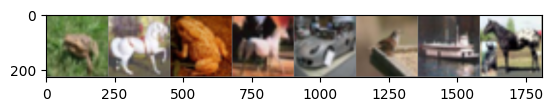

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1, Loss: 0.3121
Epoch 2, Loss: 0.1864
Epoch 3, Loss: 0.1502
Epoch 4, Loss: 0.1275
Epoch 5, Loss: 0.1140
Accuracy: 91.76%


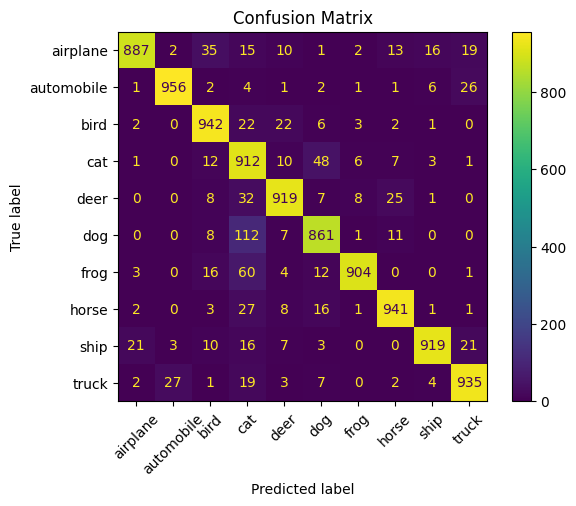

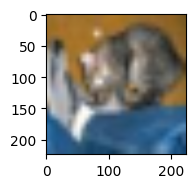

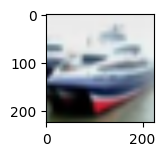

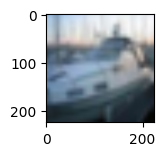

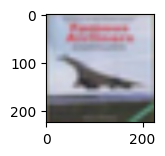

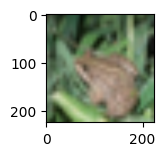

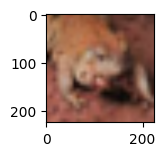

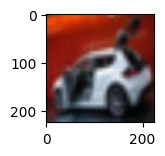

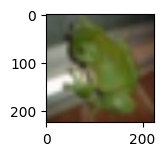

In [ ]:
# Vision Transformer (ViT) on CIFAR-10 using PyTorch - Full End-to-End Tutorial

# Step 1: Install and Import Libraries
# !pip install torchvision timm -q

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

# Step 2: Data Transforms and Loaders
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # We are adjusting the pixel values from the original [0, 1] range (after ToTensor()) to [-1, 1]
    # Helps model converge faster
    # Matches pretraining conditions
    # Avoids bias in learning
    # Keeps numerical stability
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data',
                                 train=True,
                                 download=True,
                                 transform=transform_train)

test_dataset = datasets.CIFAR10(root='./data',
                                train=False,
                                download=True,
                                transform=transform_test)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Step 3: Visualize Some Data
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8]))

# Step 4: Load Pretrained ViT Model
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=10)

# Step 5: Define Training Utilities
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Step 6: Train the Model
def train_model(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(loader):.4f}")

train_model(model, train_loader, criterion, optimizer)

# Step 7: Evaluate the Model
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return all_labels, all_preds

labels, preds = evaluate_model(model, test_loader)

# Step 8: Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(xticks_rotation=45, cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

# Step 9: Visual Predictions
def plot_predictions(model, loader):
    model.eval()
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    images = images.cpu()
    plt.figure(figsize=(12, 4))
    for idx in range(8):
        ax = plt.subplot(2, 4, idx+1)
        imshow(images[idx])
        ax.set_title(f"P: {preds[idx].item()} T: {labels[idx].item()}")
        ax.axis('off')

plot_predictions(model, test_loader)

# Done!


In [ ]:
# Save model if validation accuracy improves
torch.save(model.state_dict(), 'best_vit_model.pth')

In [ ]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [ ]:
test_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
import random

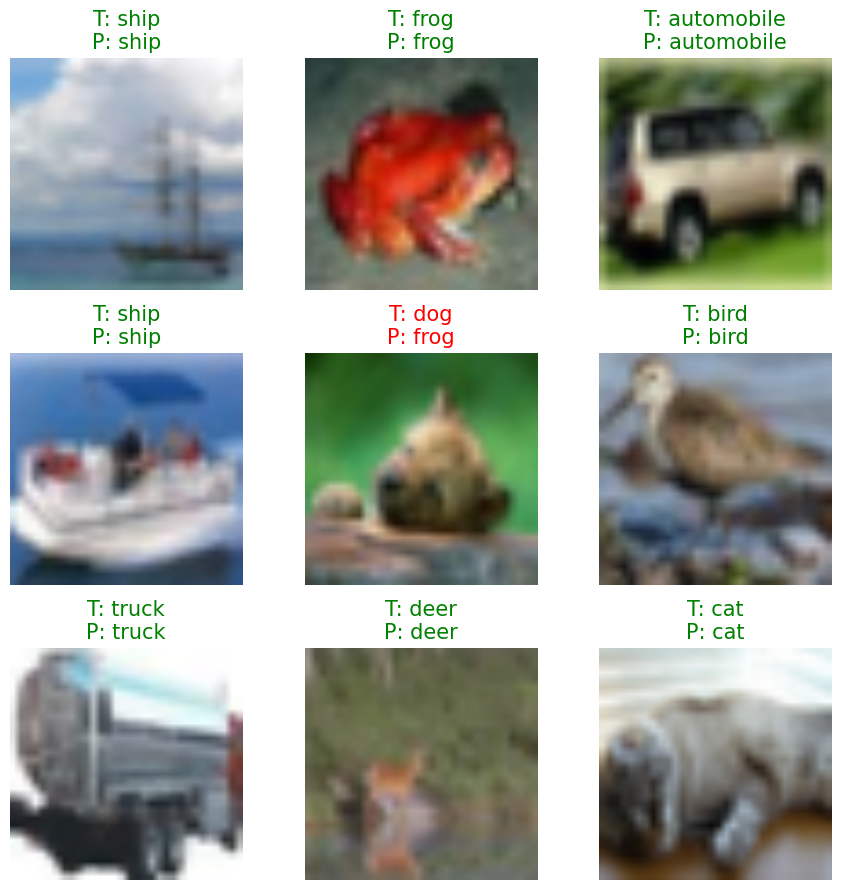

In [ ]:
# Step 9: Visual Predictions (9x9 Grid)
def predict_and_plot_grid(model, dataset, classes, grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            color = classes[true_label] == classes[predicted.item()]
            if color:
                c = "g"
            else:
                c = "r"
            axes[i, j].set_title(f"T: {classes[true_label]}\nP: {classes[predicted.item()]}", fontsize=15, c=c)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

predict_and_plot_grid(model, test_dataset, train_dataset.classes)

In [ ]:
import torch

In [ ]:
loaded_model = torch.load("/content/best_vit_model.pth", map_location=torch.device('cpu'))


In [ ]:
loaded_model

OrderedDict([('cls_token',
              tensor([[[-3.3873e-01, -2.7419e-02, -7.3160e-02,  8.7345e-02,  3.4606e-02,
                         1.0453e-01, -6.7820e-02,  8.3733e-01,  4.0378e-02, -3.6753e-02,
                         1.2473e-01,  3.6645e-02,  3.6319e-03,  6.9501e-02,  2.3210e-01,
                         1.5307e-02,  2.7196e-02,  1.3502e+00,  7.3201e-01, -6.7293e-02,
                         1.1525e-01, -1.3954e+00,  1.6127e-02, -2.8480e-02,  3.7312e-02,
                         6.7915e-02,  2.3147e-01,  6.1563e-02,  1.2705e-02,  5.5767e-02,
                        -8.2325e-01,  6.2130e-01,  3.7453e-02, -5.0591e-01, -3.4852e-02,
                         5.2813e-02,  7.6960e-02,  2.2036e-01,  5.5312e-02,  7.9246e-02,
                        -2.4718e-02,  2.6454e-01, -1.8922e-02,  6.6103e-01,  2.7521e-01,
                         4.3728e-02,  3.4191e-02,  6.2258e-01,  3.1350e-01,  2.1581e-01,
                        -5.0443e-02,  1.4206e+00, -6.2361e-02,  3.1315e-02, -2.8811